In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler


In [2]:
def normalize_dataframe(df):
    """
    Normalizes all columns in a pandas DataFrame  using MinMaxScaler.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The normalized DataFrame.
    """
    scaler = MinMaxScaler()
    columns_to_normalize = [col for col in df.columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

In [3]:
def combine_csvs_from_folder(folder_path):
    """
    Combines all CSV files in a folder into a single pandas DataFrame also normalizes before combining them.

    Args:
        folder_path (str): The path to the folder containing the CSV files.

    Returns:
        A pandas DataFrame containing the concatenated data from all CSV files in the input folder.
    """
    # Use a list comprehension to read all CSV files in the folder into a list of DataFrames.
    dfs = [pd.read_csv(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Use a list comprehension to get the filenames of all CSV files in the folder.
    filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir(folder_path) if f.endswith('.csv')]

    processed_dfs = []
    i = 0
    for df, filename in zip(dfs, filenames):
        # Dont need the date column
        df = df.drop(['date'], axis=1)
        # normalize the dataframes before combining them
        df = normalize_dataframe(df)
        # for the neural network to understand the company name we need to convert it to a number
        df['company'] = i
        i += 1
        processed_dfs.append(df)
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    
    return combined_df

df = combine_csvs_from_folder('market_data/merged_data')

df.tail()

,Chaikin A/D,ADOSC,ADX,ADXR,APO,Aroon Down,Aroon Up,AROONOSC,ATR,Real Upper Band,...,WMA,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,company
43059,0.925470,0.543459,0.271353,0.215465,0.558804,0.65,0.95,0.65,0.512792,0.961274,...,0.937124,0.717283,0.724516,0.725372,0.724509,0.984667,0.085269,0.000000,0.0,10
43060,0.924521,0.546146,0.280797,0.216888,0.602606,0.60,0.90,0.65,0.498271,0.970419,...,0.945408,0.718257,0.725454,0.730207,0.721923,0.981716,0.054010,0.000000,0.0,10
43061,0.920910,0.543406,0.278851,0.211492,0.651815,0.55,0.85,0.65,0.497862,0.976177,...,0.951449,0.715121,0.718033,0.710737,0.703099,0.961788,0.077614,0.666667,0.0,10
43062,0.924132,0.552326,0.277001,0.212026,0.734318,0.50,0.80,0.65,0.490675,0.983225,...,0.958346,0.708679,0.712659,0.711424,0.712511,0.972543,0.066541,0.000000,0.0,10
43063,0.919373,0.549282,0.282166,0.216814,0.813328,0.45,0.75,0.65,0.486867,0.992715,...,0.966062,0.728429,0.728909,0.730895,0.721923,0.983297,0.134807,0.000000,0.0,10


In [4]:
#we need this for later
def find_indices_of_last_company_changes(df):
    indices = []
    for i in range(1, len(df)):
        if df.loc[i, 'company'] != df.loc[i - 1, 'company']:
            indices.append(i-1)
    return indices
idxs = find_indices_of_last_company_changes(df)
idxs.append(len(df) - 1)

In [5]:
# we should one hot encode the company column
# first we need to change it to a string so we can one hot encode it
df['company'] = df['company'].astype(str)
df = pd.get_dummies(df, columns=['company'])

In [6]:
def add_up_column(df):
    # Create empty 'up' and 'down' columns
    df['up'] = 0
    
    # Loop over the rows (skipping the first row)
    for i in range(1, len(df)):
        if df.loc[i, '4. close'] > df.loc[i-1, '4. close']:
            df.loc[i, 'up'] = 1
    return df


df = add_up_column(df)
df.head()


,Chaikin A/D,ADOSC,ADX,ADXR,APO,Aroon Down,Aroon Up,AROONOSC,ATR,Real Upper Band,...,company_10,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9,up
0,0.176768,0.545425,0.154470,0.101243,0.431009,0.95,0.25,0.15,0.061018,0.017387,...,0,0,0,0,0,0,0,0,0,0
1,0.174206,0.532056,0.164471,0.106557,0.427970,0.90,0.20,0.15,0.061018,0.017519,...,0,0,0,0,0,0,0,0,0,0
2,0.178504,0.555077,0.164130,0.114041,0.427821,0.85,0.15,0.15,0.063319,0.017517,...,0,0,0,0,0,0,0,0,0,1
3,0.182646,0.590061,0.159311,0.123042,0.426002,0.80,0.10,0.15,0.062719,0.017436,...,0,0,0,0,0,0,0,0,0,1
4,0.178573,0.583195,0.149749,0.131813,0.423586,0.75,0.05,0.15,0.063219,0.017113,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# neural networks require tensors, so we need to convert our dataframes to tensors

def df_to_tensor(df):
    inputs_columns = df.columns[df.columns != 'up']
    inputs = torch.from_numpy(df.loc[:, inputs_columns].values.astype('float32'))
    targets = torch.from_numpy(df.loc[:, ['up']].values.astype('float32'))
    return inputs, targets


inputs, targets = df_to_tensor(df)
print(inputs[0])
print(inputs.shape)
print(targets.shape)

tensor([0.1768, 0.5454, 0.1545, 0.1012, 0.4310, 0.9500, 0.2500, 0.1500, 0.0610,
        0.0174, 0.0162, 0.0184, 0.6001, 0.3041, 0.3204, 0.0149, 0.3287, 0.0154,
        0.0770, 0.1221, 0.3806, 0.3714, 0.4913, 0.8474, 0.0167, 1.0000, 0.0145,
        0.4291, 0.4456, 0.4205, 0.4310, 0.4336, 0.3848, 0.0077, 0.0000, 0.4928,
        0.0158, 0.0159, 0.4145, 0.0368, 0.4311, 0.3511, 0.2082, 0.1884, 0.0262,
        0.7284, 0.5345, 0.5344, 0.3204, 0.0190, 0.0162, 0.1799, 0.2654, 0.3207,
        0.1799, 0.2269, 0.0756, 0.0171, 0.0140, 0.0221, 0.0167, 0.7760, 0.3570,
        0.1964, 0.0155, 0.1429, 0.1544, 0.1394, 0.1461, 0.0132, 0.0213, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
torch.Size([43064, 84])
torch.Size([43064, 1])


In [8]:
def create_sequences(inputs, targets, seq_length):
    seq_inputs = []
    seq_targets = []
    for i in range(len(inputs) - seq_length):
        seq_inputs.append(inputs[i:i + seq_length])
        seq_targets.append(targets[i + seq_length])
    return torch.stack(seq_inputs), torch.stack(seq_targets)

sequence_length = 10
seq_inputs, seq_targets  = create_sequences(inputs, targets, sequence_length)

In [9]:
# making a training and validation dataset

dataset = TensorDataset(seq_inputs, seq_targets)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
# pytorch uses dataloaders to load data in batches

batch_size = 256
train_loader = DataLoader(dataset, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, 1, shuffle = False, num_workers = 0)

In [11]:
# use gpu if avaliable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
class LSTM_NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# input size is 84 because we have 84 columns in our dataframe
# output size is 1 because we are predicting up=1 or down=0
input_size = 84
output_size = 1
hidden_size = 84
num_layers = 2
model = LSTM_NN(input_size, hidden_size, num_layers, output_size)
model.to(device)

LSTM_NN(
  (lstm): LSTM(84, 84, num_layers=2, batch_first=True)
  (fc): Linear(in_features=84, out_features=1, bias=True)
)

In [21]:
# hyperparameters for training
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 100

In [22]:
# training loop
training_losses = []
sequence_length = 10
for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.view(-1, sequence_length, input_size)
        inputs, targets = inputs.to(device), targets.to(device)
        # forward pass
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, targets)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #average the loss over all batches
    avg_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_loss)
    if(epoch % 10 == 0 or epoch == 1):
        print(f'epoch: {epoch}, avg_loss: {avg_loss}')

epoch: 1, avg_loss: 0.6929363894039358
epoch: 10, avg_loss: 0.6895449062776283
epoch: 20, avg_loss: 0.6789701066073581
epoch: 30, avg_loss: 0.6507334395273198
epoch: 40, avg_loss: 0.5876412201209886
epoch: 50, avg_loss: 0.4881404682376681
epoch: 60, avg_loss: 0.38946381458163964
epoch: 70, avg_loss: 0.30170433099805954
epoch: 80, avg_loss: 0.23716625897489355
epoch: 90, avg_loss: 0.19536092947926043
epoch: 100, avg_loss: 0.1829669413834634


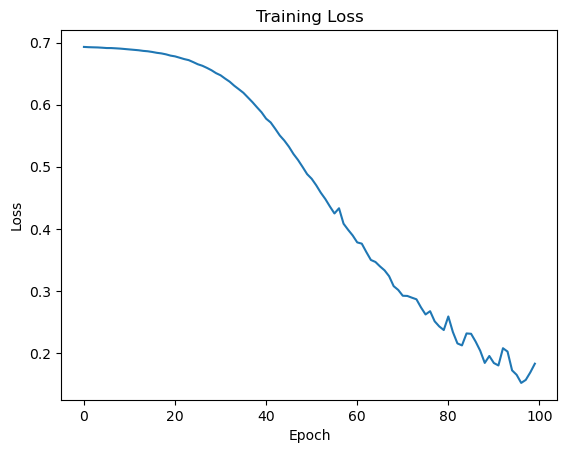

In [23]:
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [24]:
def validate(model, dataloader, criterion):
    model.eval() # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    flag = 0
    
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, targets in dataloader:
            inputs = inputs.view(-1, sequence_length, input_size)
            inputs, targets = inputs.to(device), targets.to(device) # Move data to GPU if available
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, targets.float()) # BCE loss expects float inputs
            val_loss += loss.item() * inputs.size(0) # Track total validation loss
            
            # Calculate accuracy
            if flag == 0:
                print(targets)
                print(torch.round(torch.sigmoid(outputs)))
                flag = 1
            predicted = torch.round(torch.sigmoid(outputs))
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    # Calculate average validation loss and accuracy
    val_loss /= len(dataloader.dataset)
    accuracy = correct / total
    
    return val_loss, accuracy

val_loss, val_acc = validate(model, val_loader, criterion)
print(f'val_loss: {val_loss}, val_acc: {val_acc}')

tensor([[0.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
val_loss: 0.17529431852307104, val_acc: 0.5437231448147718


In [ ]:
#not yet working for LSTM model

# how will visa do tomorrow? > 0.5 = up, < 0.5 = down
inputs, targets = df_to_tensor(df)
inputs = inputs.to(device)
print(inputs[len(inputs)-1])
model(inputs[len(inputs)-1])

tensor([0.8384, 0.6218, 0.0964, 0.1332, 0.7610, 0.1500, 0.8000, 0.8250, 0.3453,
        0.9183, 0.9200, 0.9199, 0.7466, 0.7152, 0.5881, 0.9176, 0.1422, 0.9272,
        0.1510, 0.6481, 0.4280, 0.4814, 0.4289, 0.0998, 0.9250, 1.0000, 0.9338,
        0.7940, 0.7269, 0.6243, 0.7610, 0.7181, 0.5339, 0.9604, 0.9982, 0.7262,
        0.9215, 0.9080, 0.3292, 0.2287, 0.7729, 0.0916, 0.9254, 0.4240, 0.3633,
        0.5953, 0.5943, 0.5943, 0.5881, 0.8577, 0.9200, 0.5049, 0.5539, 0.7208,
        0.5049, 0.8912, 0.3345, 0.9084, 0.9210, 0.1042, 0.9145, 0.6438, 0.7618,
        0.9248, 0.9222, 0.7811, 0.7888, 0.7927, 0.7887, 0.9190, 0.0442, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000], device='cuda:0')


AssertionError: LSTM: Expected input to be 2-D or 3-D but received 1-D tensor

In [ ]:
filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir("market_data/merged_data/") if f.endswith('.csv')]

for i, idx in enumerate(idxs):
    print(f"{filenames[i]}: {model(inputs[idx]).item():.2f}")
